In [1]:
# %load_ext cuml.accel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os  # 导入os库来处理文件和目录
import glob # 导入glob库来查找文件

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

In [2]:
def load_data_from_subjects(root_dir, eeg_suffix='EEG_aligned.npy' , sound_suffix='Sound_aligned.npy',root_suffix = 'feature_normalized'):
    all_eeg_data = []
    all_sound_data = []


    subject_folders = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir,f))]

    if not subject_folders:
        print('No subjects found')
        return None, None

    print(f"found{len(subject_folders)}folders")
    for subject_folder in subject_folders:
        subject_folder_path = os.path.join(root_dir, subject_folder , root_suffix)


        eeg_files = glob.glob(os.path.join(subject_folder_path,f'*{eeg_suffix}'))

        if not eeg_files:
            print(f'No EEG found in folder {subject_folder_path}')
            continue

        for eeg_file_path in eeg_files:
            base_name = os.path.basename(eeg_file_path).replace('EEG_aligned.npy', '')
            sound_file_path = os.path.join(subject_folder_path,base_name + sound_suffix)

            if os.path.exists(sound_file_path):
                try:
                    eeg_data = np.load(eeg_file_path)
                    sound_data = np.load(sound_file_path)

                    if eeg_data.shape[0] == sound_data.shape[0]:
                        all_eeg_data.append(eeg_data)
                        all_sound_data.append(sound_data)
                    else :
                        print(f"warning: Size not matching for {os.path.basename(eeg_file_path)}and {os.path.basename(sound_file_path)}")
                except Exception as e:
                    print(e)
            else:
                print(f"warning: for {os.path.basename(eeg_file_path)} sound file not found")

    if not all_eeg_data:
        print('No EEG found')
        return None, None

    X = np.vstack(all_eeg_data)
    Y = np.vstack(all_sound_data)

    return X, Y

In [3]:
ROOT_DATA_DIR = r'/content/drive/MyDrive/data'

X,Y = load_data_from_subjects(ROOT_DATA_DIR)

found20folders
No EEG found in folder /content/drive/MyDrive/data/CLIP_VIE_RechLn4_Cer&LIUJ25m_EP008/feature_normalized
No EEG found in folder /content/drive/MyDrive/data/CLIP_VIE_RechLn4_Cer&WANGX25f_EP016/feature_normalized
No EEG found in folder /content/drive/MyDrive/data/CLIP_VIE_RechLn4_Cer&XIAOZ18f_EP018/feature_normalized
No EEG found in folder /content/drive/MyDrive/data/ish/feature_normalized
No EEG found in folder /content/drive/MyDrive/data/Stimuli/feature_normalized


In [4]:
if X is None or Y is None:
    print('No data found')
    exit(0)

print(f"{X.shape}")
print(f"{Y.shape}")


(653016, 32)
(653016, 54)


In [5]:
feature_names = [f'feature_{i+1}' for i in range(Y.shape[1])]
Y_df = pd.DataFrame(Y, columns=feature_names)


In [6]:
correlation_matrix = Y_df.corr()

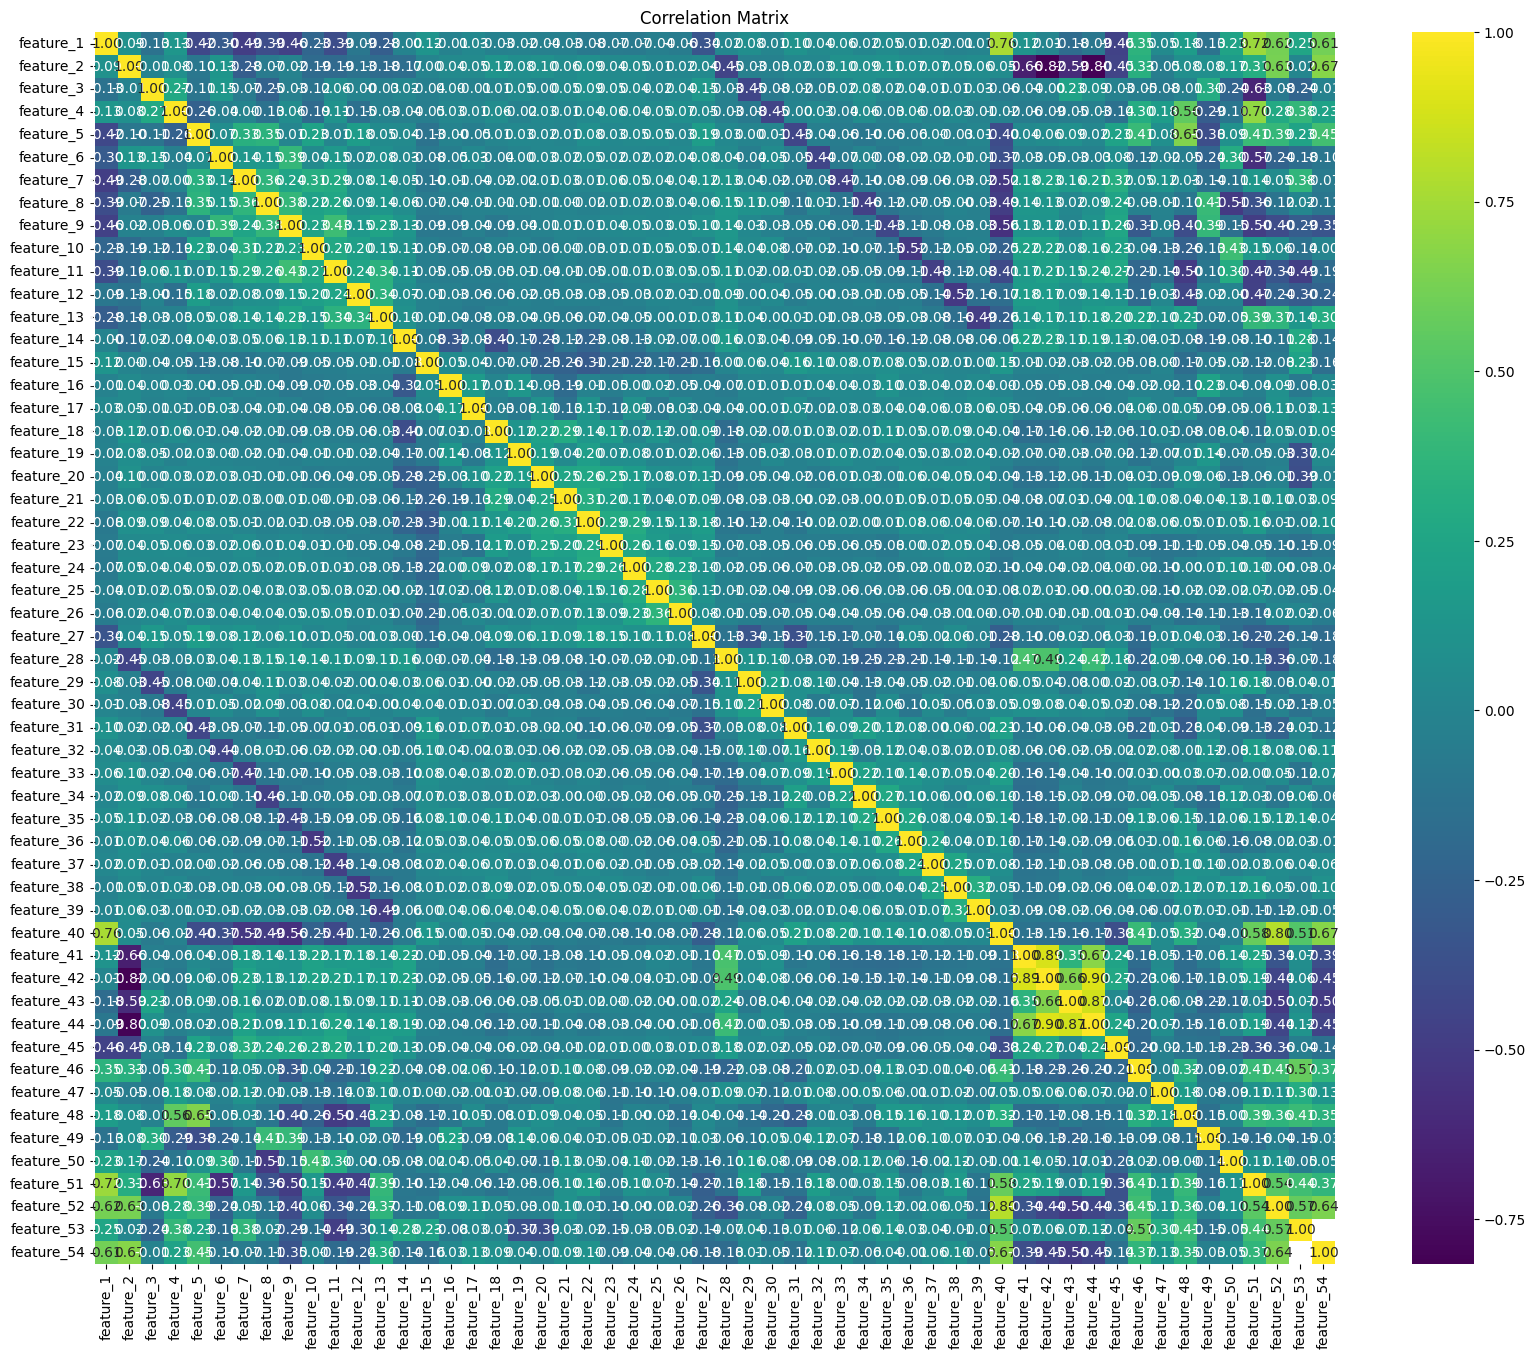

In [7]:
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [8]:
imputer = SimpleImputer(strategy='mean')
Y_imputed = imputer.fit_transform(Y)

In [9]:
scaler = StandardScaler()
Y_scaled = scaler.fit_transform(Y_imputed)

In [10]:
pca_explorer = PCA(n_components=0.95)
pca_explorer.fit(Y_scaled)

PCA(n_components=0.95)

In [11]:
n_components_retained = pca_explorer.n_components_
print(f"Number of components retained: {n_components_retained}")

Number of components retained: 42


In [12]:
explained_variance = pca_explorer.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

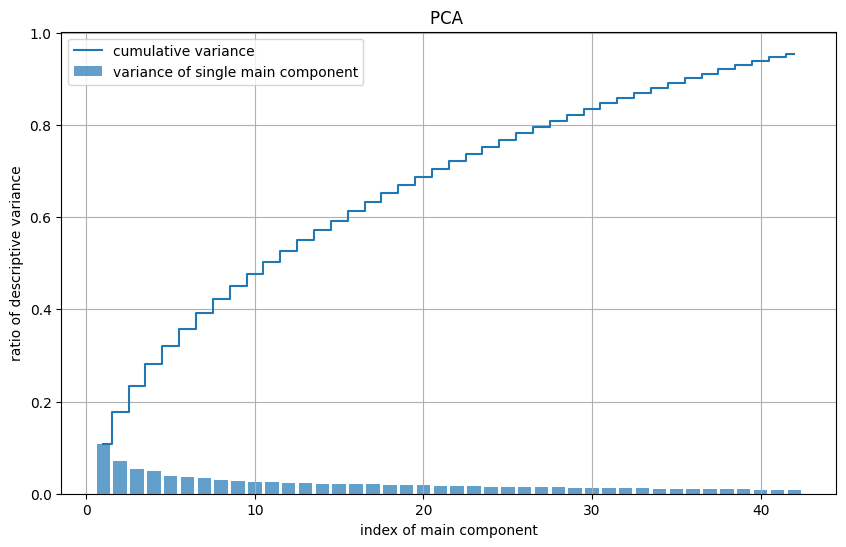

In [13]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center',
        label='variance of single main component')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid',
         label='cumulative variance')
plt.ylabel('ratio of descriptive variance')
plt.xlabel('index of main component')
plt.title('PCA ')
plt.legend(loc='best')
plt.grid()
plt.show()

In [14]:
pca_transformer = PCA(n_components=n_components_retained)
Y_pca = pca_transformer.fit_transform(Y_scaled)

In [15]:
feature_names = [f'feature_{i+1}' for i in range(X.shape[1])]
X_df = pd.DataFrame(X, columns=feature_names)

In [16]:
correlation_matrix_X = X_df.corr()

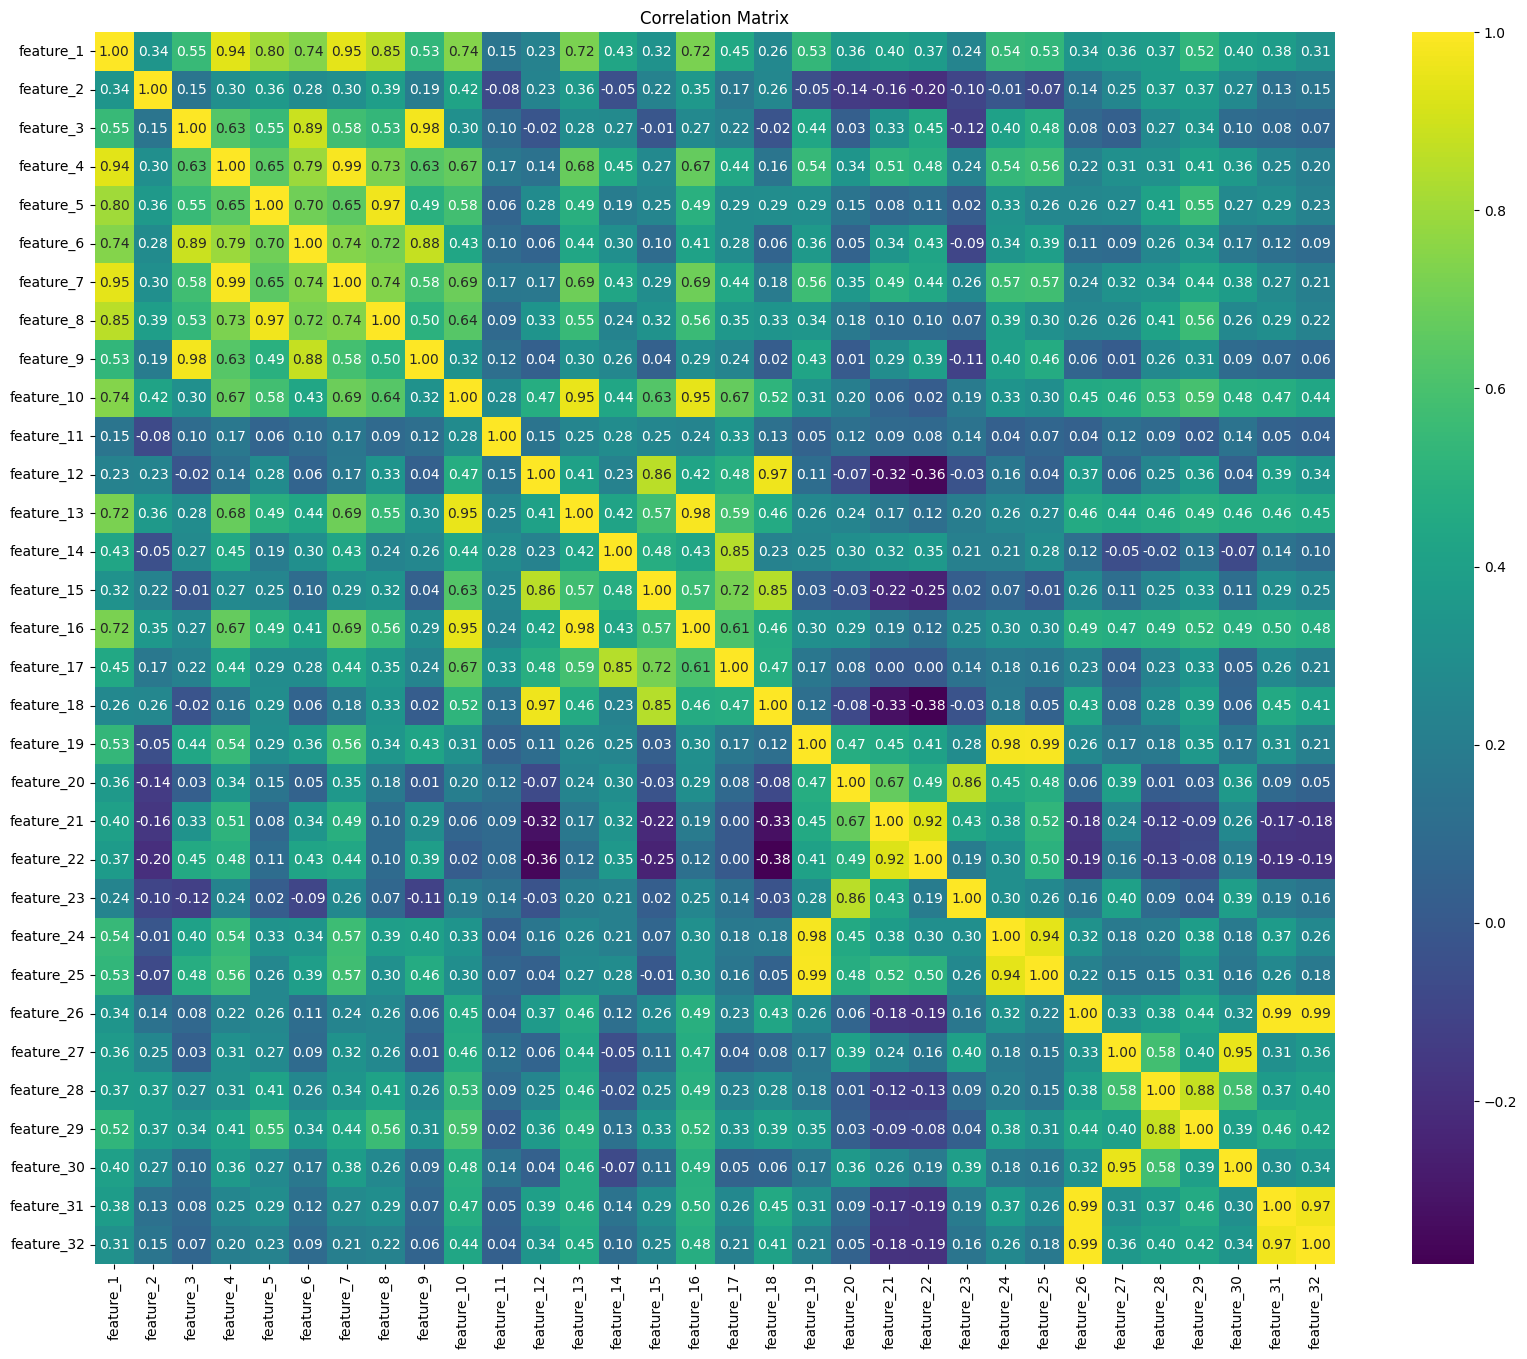

In [17]:
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix_X, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [18]:
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

In [19]:
pca_explorer_X = PCA(n_components=0.95)
pca_explorer_X.fit(X_scaled)

PCA(n_components=0.95)

In [20]:
n_components_retained_X = pca_explorer_X.n_components_
print(f"Number of components retained: {n_components_retained_X}")

Number of components retained: 12


In [21]:
explained_variance_X = pca_explorer_X.explained_variance_ratio_
cumulative_variance_X = np.cumsum(explained_variance_X)

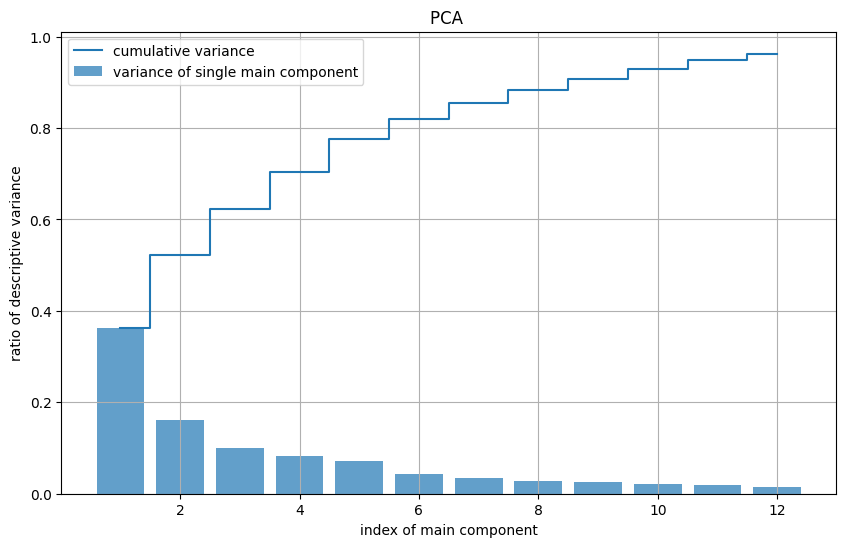

In [22]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_X) + 1), explained_variance_X, alpha=0.7, align='center',
        label='variance of single main component')
plt.step(range(1, len(cumulative_variance_X) + 1), cumulative_variance_X, where='mid',
         label='cumulative variance')
plt.ylabel('ratio of descriptive variance')
plt.xlabel('index of main component')
plt.title('PCA ')
plt.legend(loc='best')
plt.grid()
plt.show()

In [23]:
pca_transformer = PCA(n_components=n_components_retained_X)
X_pca = pca_transformer.fit_transform(X_scaled)

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y_pca, test_size=0.2, random_state=42)

In [25]:
imputer_y = SimpleImputer(missing_values=np.nan, strategy='mean')
Y_train = imputer_y.fit_transform(Y_train)
Y_test = imputer_y.transform(Y_test)

model_pipeline = Pipeline(steps=[('imputer',SimpleImputer(strategy='mean')),('scaler', StandardScaler()),('ridge', Ridge(alpha=1.0))])
model_pipeline.fit(X_train, Y_train)

Y_pred = model_pipeline.predict(X_test)
R2 = r2_score(Y_test, Y_pred)
RMSE = mean_squared_error(Y_test, Y_pred)

print(R2,RMSE)

0.00010779925651149824 1.2281172275543213


In [26]:
rf_model = RandomForestRegressor(
    n_estimators=150,       # 增加树的数量
    random_state=42,
    n_jobs=-1,              # 使用所有CPU核心
    max_depth=20,           # 适当增加深度
    min_samples_leaf=10,    # 每个叶节点最少样本数，防止过拟合
    max_features=0.5        # 每次分裂只考虑50%的特征
)

In [ ]:
rf_model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=20, max_features=0.5, min_samples_leaf=10,
                      n_estimators=150, n_jobs=-1, random_state=42)

In [ ]:
Y_pred = rf_model.predict(X_test)
R2 = r2_score(Y_test, Y_pred)
RMSE = mean_squared_error(Y_test, Y_pred)

In [ ]:
print(R2,RMSE)

0.007438891548637792 1.2174443222712281
